In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [20]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 3.4MB/s 


In [26]:
!pip install statsmodels

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [0]:
rv = drive.CreateFile({"id":"1PaFPoD8jmnXR_jKcAsJNR9QhTJd5cmE2"})
rv.GetContentFile("RestaurantVisitors.csv")
rv = pd.read_csv("RestaurantVisitors.csv", index_col = "date", parse_dates = True)


In [5]:
rv.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


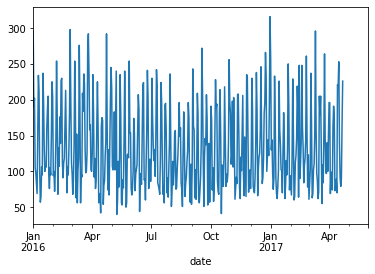

In [6]:
rv["total"].plot()

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title = ""):
  print(f'Augmented Dickey-fuller test : {title}')
  result = adfuller(series.dropna(),autolag='AIC')

  labels = ['ADF test statistic','p-value','# lags used','# Observations']
  out = pd.Series(result[0:4], index = labels)

  for key, val in result[4].items():
    out[f'critical value ({key})'] = val

  print(out.to_string())
  if result[1] <=0.05:
    print("Strong evidence against null hypothesis")
    print("Reject the null hypothesis")
    print("Data has no unit root and is stationary")
  else:
    print("Weak evidence against the null hypothesis")
    print("Fail to reject the null hypothesis")
    print("Data has a unit root and is non-stationary")


In [8]:
adf_test(rv["total"])

Augmented Dickey-fuller test : 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# Observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [0]:
rv.index.freq = "D"

In [0]:
rv1 = rv.dropna()

In [0]:
cols = ["rest1","rest2","rest3","rest4","total"]
for i in cols:
  rv1[i] = rv1[i].astype(int)

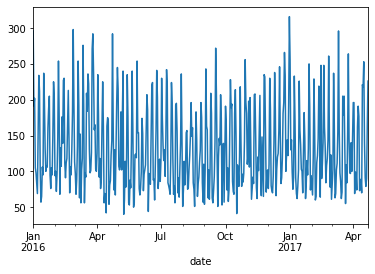

In [12]:
rv1["total"].plot()

In [13]:
rv1[rv1["holiday"] == 1].index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

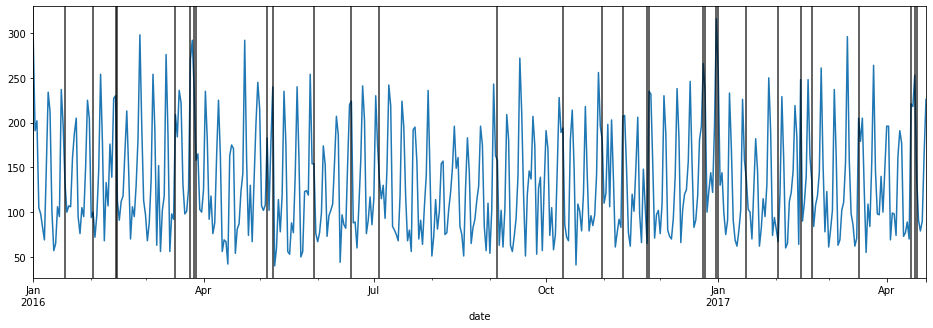

In [14]:
ax = rv1["total"].plot(figsize=(16,5))

for day in rv1.query('holiday ==1').index:
  ax.axvline(x=day, color = "black", alpha = 0.8)

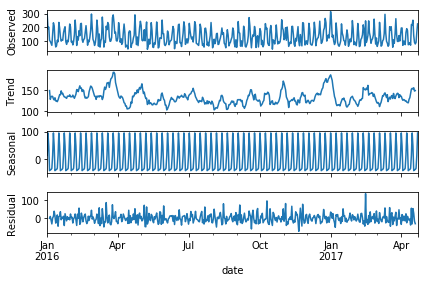

In [16]:
result = seasonal_decompose(rv1['total'])
result.plot();


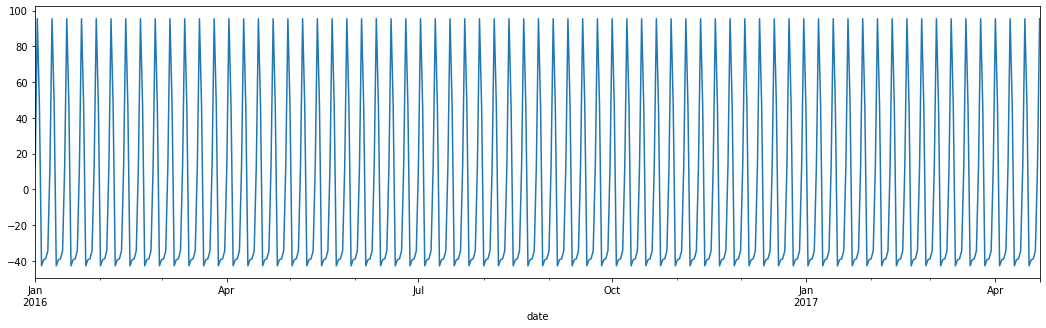

In [17]:
result.seasonal.plot(figsize=(18,5))

In [18]:
len(rv1)

478

In [0]:
train = rv1.iloc[:436]
test = rv1.iloc[436:]


In [56]:
auto_arima(rv1["total"],seasonal = True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:                       y   No. Observations:                  478
Model:             SARIMAX(1, 0, 1, 7)   Log Likelihood               -2387.926
Date:                 Sun, 26 Jan 2020   AIC                           4783.852
Time:                         20:57:42   BIC                           4800.531
Sample:                              0   HQIC                          4790.409
                                 - 478                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.0699      2.102      2.887      0.004       1.949      10.191
ar.S.L7        0.9534      0.016     60.039      0.000       0.922       0.985
ma.S.L7       -0.7315      0.056    -13.101      0.000      -0.841      -0.622
sigma2      1357.6408     88.981     15.258      0.000    1183.242    1532.040
===================================================================================
Ljung-Box (Q):                       73.59   Jarque-Bera (JB):                58.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.73
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
model = SARIMAX(rv["total"],seasonal_order=(1,0,1,7), enforce_invertibilty = False)

In [0]:
results=model.fit()

In [0]:
start = len(train)
end = len(train)+len(test) - 1

In [0]:
predictions = results.predict(start,end).rename('Sarima model')

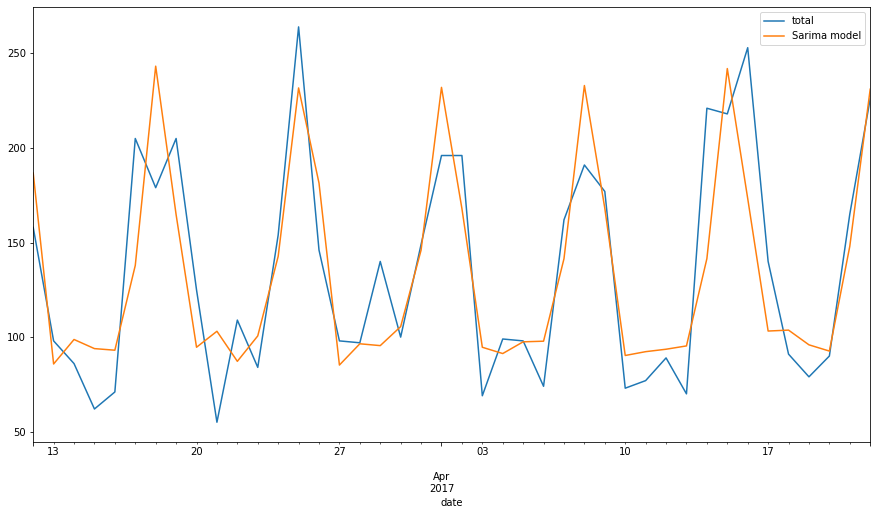

In [34]:
test['total'].plot(legend = True, figsize=(15,8))
predictions.plot(legend = True)

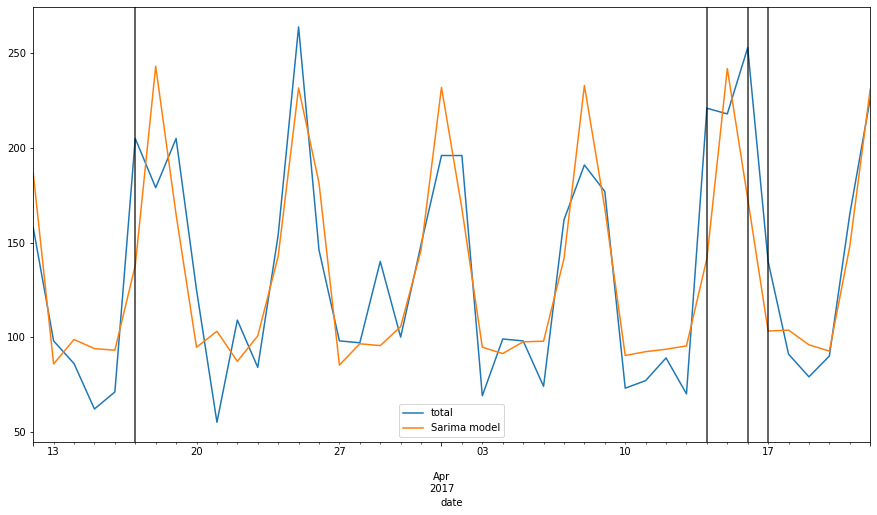

In [35]:
ax = test['total'].plot(legend = True, figsize=(15,8))
predictions.plot(legend = True)

for day in test.query('holiday==1').index:
  ax.axvline(x=day, color = "black", alpha = 0.8)

In [0]:
from statsmodels.tools.eval_measures import rmse

In [37]:
rmse(test['total'],predictions)

32.25460474313857

In [38]:
test['total'].mean()

134.26190476190476

In [57]:
auto_arima(rv1["total"],exogenous = rv1[["holiday"]], seasonal = True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 7)   Log Likelihood               -2352.074
Date:                           Sun, 26 Jan 2020   AIC                           4716.148
Time:                                   20:58:41   BIC                           4741.166
Sample:                               01-01-2016   HQIC                          4725.984
                                    - 04-22-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.0543      2.850      5.634      0.000      10.469      21.639
holiday       45.9411      4.303     10.676      0.000      37.507      54.375
ar.L1          0.0462      0.046      1.004      0.316      -0.044       0.136
ar.S.L7        0.8725      0.022     40.019      0.000       0.830       0.915
ma.S.L7       -0.4876      0.059     -8.335      0.000      -0.602      -0.373
sigma2      1037.9156     70.910     14.637      0.000     898.934    1176.897
===================================================================================
Ljung-Box (Q):                      115.75   Jarque-Bera (JB):                 8.07
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.89   Skew:                             0.31
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
model = SARIMAX(train["total"],exog=train[["holiday"]], order=(1,0,0), seasonal_order = (1,0,1,7), enforce_invertibility = False)

In [0]:
result = model.fit()

In [60]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 7)   Log Likelihood               -2089.208
Date:                           Sun, 26 Jan 2020   AIC                           4188.417
Time:                                   20:58:52   BIC                           4208.805
Sample:                               01-01-2016   HQIC                          4196.463
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.9347      3.773     18.271      0.000      61.540      76.329
ar.L1          0.2101      0.044      4.763      0.000       0.124       0.297
ar.S.L7        1.0000   5.78e-05   1.73e+04      0.000       1.000       1.000
ma.S.L7       -0.9581      0.022    -43.532      0.000      -1.001      -0.915
sigma2       779.3165     44.867     17.370      0.000     691.379     867.254
===================================================================================
Ljung-Box (Q):                       36.17   Jarque-Bera (JB):                20.47
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.22
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
start = len(train)
end = len(train)+len(test) - 1

In [0]:
predictions = result.predict(start, end,exog=test[["holiday"]]).rename('Saxrimax with exog')

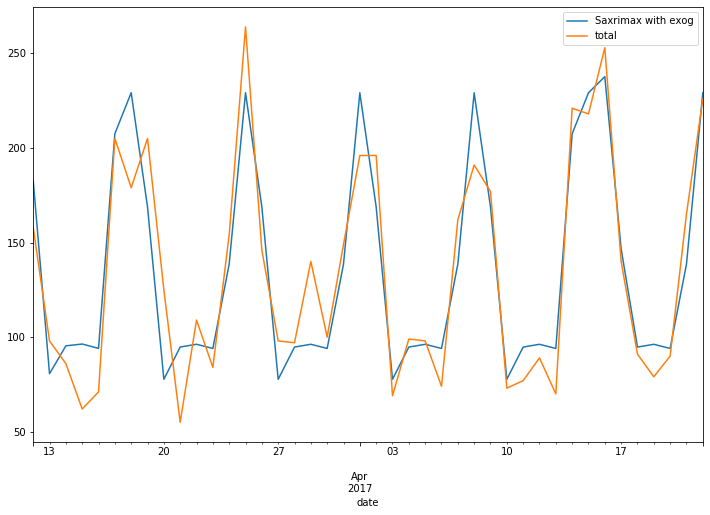

In [63]:
predictions.plot(figsize = (12,8), legend= True)
test["total"].plot(legend = True)

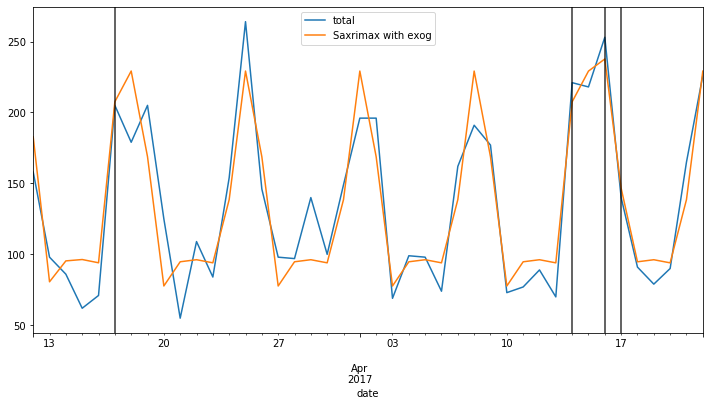

In [64]:
ax= test["total"].plot(legend = True, figsize=(12,6))
predictions.plot(legend = True)

for x in test.query('holiday==1').index:
  ax.axvline(x=x,color="k",alpha=0.8)

In [65]:
rmse(test["total"],predictions)

22.929760570128547

In [0]:
model = SARIMAX(rv["total"],exog = rv[["holiday"]],order=(1,0,0), seasonal_order = (1,0,1,7), enforce_invertibility = False)

In [0]:
results=model.fit()

In [0]:
exog_forecast = rv[477:][["holiday"]]

In [0]:
fcast = results.predict(len(rv1),len(rv1)+38,exog = rv1[477:][["holiday"]]).rename("Final SARIMAX")

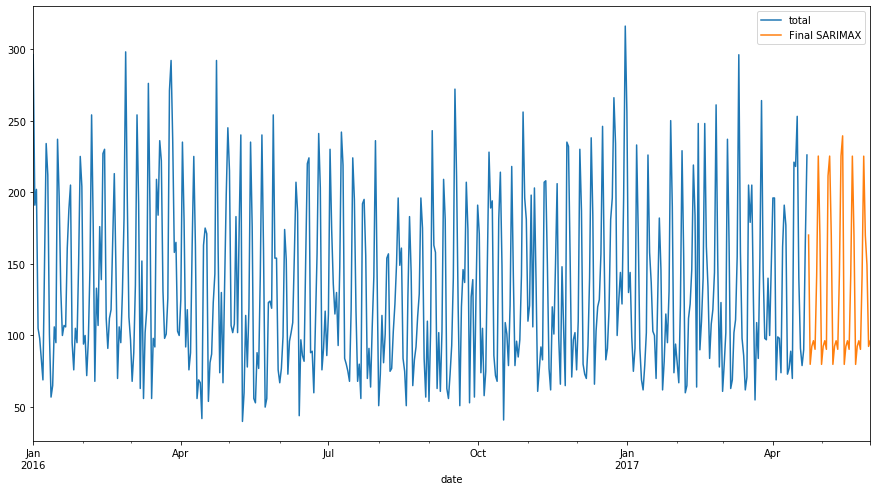

In [70]:
rv1["total"].plot(figsize=(15,8), legend = True)
fcast.plot(legend = True)

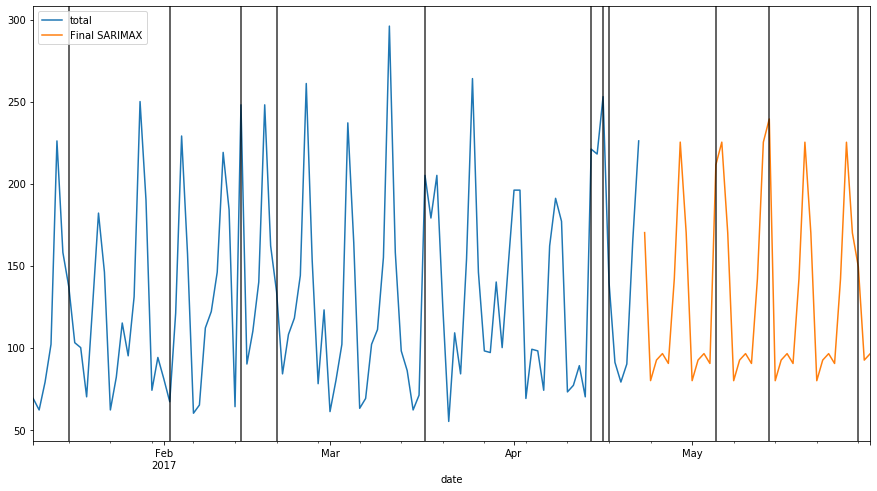

In [71]:
ax = rv1["total"].loc["2017-01-10":].plot(figsize=(15,8), legend = True)
fcast.plot(legend = True)

for x in rv.query("holiday==1").index:
  ax.axvline(x=x, color="k", alpha = 0.8)